<a href="https://www.dialogasia.com/"><img src = "https://www.eog-asia.com/wp-content/uploads/2018/02/Dialog-Group.jpg" width = 200> 

<h1 align=center><font size = 5>Core Analysis Baram Delta</font></h1>

<h1 align=center><font size = 4> Munish Kumar </font></h1>
<h1 align=center><font size = 4> P5935_Baram_Junior_Cluster_DRO </font></h1>
<h1 align=center><font size = 3> ERCE 2022 </font></h1>

#### Libraries

In [1]:
# Only install the following libraries if you dont have it, otherwise leave it commented out

#!conda install -c anaconda natsort --yes
#!conda install -c anaconda xlrd --yes
#!pip install sympy --user

# General Libraries
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter
import time
import re
import requests
import pickle
import seaborn as sns
import os
import glob
import sys
from natsort import natsorted
sns.set()

# Sklearn Liraries
from sklearn import preprocessing

# For Latex style text
from sympy import S, symbols, printing

import datetime
from datetime import timedelta, date 
start = time.time()
%matplotlib inline

# Forces the print statement to show everything and not truncate
# np.set_printoptions(threshold=sys.maxsize) 
print('Libraries imported')

Libraries imported


###### Declare some global variables

In [2]:
dir_name = r'C:\Users\mkumar\Documents\GitHub\Core_Analysis_BD_Dialog'
filename_suffix = 'csv'

# Font, marker size and axis rotation
edgecolors = 'black'
markersize = 16
alpha = 0.5
size = 18
rotation = 0

###### Series of Functions

In [3]:
# Function to look at first 5 and last 5 elements in a dataframe
def ends(df, x=5):
    return df.head(x).append(df.tail(x))
setattr(pd.DataFrame,'ends',ends)

In [4]:
# Function to read out file
def file_out(df, dir_name, base_filename, filename_suffix):
    try:
        csvs_sht = os.path.join(dir_name, base_filename + "." + filename_suffix)
        df.to_csv(csvs_sht, index = False, header=True)
        print ("Final File Extract Produced")
    except IOError:
        print("I/O error")
    return

In [5]:
# Function to search for a text string
def search_words(text):
    result = re.findall(r'\b[^\d\W]+\b', text)
    return " ".join(result)

In [6]:
# Function to plot grain density
def plot_grain_density(mod_df, title, savefn):
    sns.set()
    sns.set_style("whitegrid")     
    sns.set_style("ticks", 
                  {"xtick.major.size":size,
                  "ytick.major.size":size}
                 )
    sns.axes_style("whitegrid")
    kwargs = {'cumulative': True}

    ax = sns.distplot(mod_df['Grain Density (g/cc)'], 
                      bins = 20, 
                      kde=True, 
                      color = 'r',
                      #bw_adjust=.25,
                      #hist_kws=kwargs, 
                      #kde_kws=kwargs
                     )
    ax.set(ylabel='Frequency', 
           #xlabel='common ylabel',
           xlim = (2.6, 2.8),
          )

    ax.legend(labels=['Histogram', 'Frequency'])
    plt.title(title)
    plt.grid(True)

    plt.savefig(savefn, transparent=True)
    return

In [7]:
# Plotting the effect of NOBP
def plot_NOBP(mod_df, df_sub, grouped, color, savefn):
    # Plot per group
    fig = plt.figure(figsize=(14, 8))
    ax = fig.add_subplot(121)

    for i, (name, group) in enumerate(grouped):
        sc = ax.scatter(
            group["NOB (psi)"],
            group["Porosity (%)"],
            s = markersize**2,
            alpha=0.5,
            label=name,
            edgecolors = edgecolors,
        )  

    # Add legends (one for gender, other for size)
    ax.add_artist(ax.legend(title='Well Name'))
    ax.legend(*sc.legend_elements("colors", num=6))
    ax.set_xlabel('Net Overburden Pressure (psi)', fontsize=size)
    ax.set_ylabel('Porosity (%)', fontsize=size)

    plt.xticks(rotation = rotation, fontsize=size)
    plt.yticks(rotation = rotation, fontsize=size)
    plt.ylim(0,20) 
    plt.grid(True)
    
    ax1 = fig.add_subplot(122)

    for i, (name, group) in enumerate(grouped):
        sc1 = ax1.scatter(
            group["NOB (psi)"],
            group["K_klin (mD)"],
            s = markersize**2,
            alpha=0.5,
            label=name,
            edgecolors = edgecolors,
        )  

    # Add legends (one for gender, other for size)
    ax1.add_artist(ax1.legend(title='Well Name'))
    ax1.legend(*sc1.legend_elements("colors", num=6))
    ax1.set_xlabel('Net Overburden Pressure (psi)', fontsize=size)
    ax1.set_ylabel('Permeability (mD)', fontsize=size)

    plt.xticks(rotation = rotation, fontsize=size)
    plt.yticks(rotation = rotation, fontsize=size)
    #plt.ylim(0,20)

    plt.tight_layout()
    plt.grid(True)

    plt.savefig(savefn, transparent=True)
    return

In [8]:
def plot_PP(mod_df, df_sub, grouped, color, title, savefn):
    fig = plt.figure(figsize=(14, 8))
    ax = fig.add_subplot(111)

    for i, (name, group) in enumerate(grouped):
        sc = ax.scatter(
            group["Porosity (%)"],
            group["K_klin (mD)"],
            s = markersize**2,
            alpha=0.5,
            label=name,
            edgecolors = edgecolors,
        )  

    # Add legends (one for gender, other for size)
    ax.add_artist(ax.legend(title='Well Name'))
    ax.legend(*sc.legend_elements("colors", num=6), prop={'size': 20})
    ax.set_xlabel('Porosity (%)', fontsize=size)
    ax.set_ylabel('Permeability (mD)', fontsize=size)

    plt.xticks(rotation = rotation, fontsize=size)
    plt.yticks(rotation = rotation, fontsize=size)
    plt.xlim(0,20)

    # Fit to linear-log
    y1 = df_sub["Porosity (%)"]
    y2 = df_sub["K_klin (mD)"]
    p = np.polyfit(y1, np.log(y2), 1)
    f = np.poly1d(p)

    ax.semilogy(y1, np.exp(p[0] * y1 + p[1]), 'b--', linewidth = 2.5)
    ax.set_yscale('log')

    #Display Equation
    plt.text(16, 10, r'Equation ={}'.format(f), fontsize = size)
    plt.title (title, fontsize = size)

    plt.tight_layout()
    plt.grid(True)

    plt.savefig(savefn, transparent=True)
    return

##### Read in the data and some preprocessing

In [9]:
# Header file comes preformatted as 1st row is variable name, 2nd row reads "Low, Best, High"
# Combines the first 2 rows of header into 1 header

df = pd.read_excel(
    'Cluster 3 Offset Core Data.xlsx', 
    header=[0, 1], 
    sheet_name='MASTER', 
    keep_default_na=False,
    #usecols="A,C:AA"
)
df.columns=df.columns.to_flat_index()

# renaming the columns
df.columns = ['Well Name', 'Depth (m)', 'NOB (psi)', 'K_klin (mD)', 'Porosity (%)', 'Grain Density (g/cc)']
df.ends(10)

C:\Users\mkumar\AppData\Local\Temp\ipykernel_16780\3237448987.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.head(x).append(df.tail(x))


,Well Name,Depth (m),NOB (psi),K_klin (mD),Porosity (%),Grain Density (g/cc)
0,Tukau Timur West 1,3323.579615,800,103,18.3,2.67
1,Tukau Timur West 1,3323.579615,3633,97,17.7,2.67
2,Tukau Timur West 1,3323.640575,800,73.2,18.1,2.66
3,Tukau Timur West 1,3323.640575,3633,68.3,17.3,2.66
4,Tukau Timur West 1,3323.853938,800,84.3,17.6,2.67
5,Tukau Timur West 1,3323.853938,3633,78.8,16.9,2.67
6,Tukau Timur West 1,3324.097781,800,1.4,12.1,2.69
7,Tukau Timur West 1,3324.097781,3633,1.09,11.3,2.69
8,Tukau Timur West 1,3324.311144,800,3.02,13.4,2.67
9,Tukau Timur West 1,3324.311144,3633,2.44,12.7,2.67


##### Remove Missing Rows based on Missing Permeability and Porosity Values

In [10]:
df = df.replace(r'^\s*$', np.nan, regex=True)

cols = ['K_klin (mD)', 'Porosity (%)']

mod_df = df.dropna(how='any', subset=cols)
mod_df

,Well Name,Depth (m),NOB (psi),K_klin (mD),Porosity (%),Grain Density (g/cc)
0,Tukau Timur West 1,3323.579615,800.0,103.000,18.3,2.67
1,Tukau Timur West 1,3323.579615,3633.0,97.000,17.7,2.67
2,Tukau Timur West 1,3323.640575,800.0,73.200,18.1,2.66
3,Tukau Timur West 1,3323.640575,3633.0,68.300,17.3,2.66
4,Tukau Timur West 1,3323.853938,800.0,84.300,17.6,2.67
...,...,...,...,...,...,...
2031,Laila 3,3769.796880,4100.0,3.280,13.8,2.66
2032,Laila 3,3770.101680,4100.0,0.192,10.8,2.67
2033,Laila 3,3770.406480,4100.0,0.085,10.9,2.68
2034,Laila 3,3770.406480,4100.0,0.417,12.4,2.68


####### Mapping each well to a colour

In [11]:
df_colors = pd.read_csv('https://raw.githubusercontent.com/codebrainz/color-names/master/output/colors.csv',header=None)
df_colors.columns = ['color_name', 'color_description', 'hex_value', 'r', 'g','b']

names = mod_df['Well Name'].unique()
c = df_colors[['hex_value']].astype(str).agg(','.join,axis=1).tolist()
colors = dict(zip(names,c))

mod_df['color'] = mod_df['Well Name'].apply(lambda x: colors[x])
mod_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1967 entries, 0 to 2035
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Well Name             1967 non-null   object 
 1   Depth (m)             660 non-null    float64
 2   NOB (psi)             660 non-null    float64
 3   K_klin (mD)           1967 non-null   float64
 4   Porosity (%)          1967 non-null   float64
 5   Grain Density (g/cc)  660 non-null    float64
 6   color                 1967 non-null   object 
dtypes: float64(5), object(2)
memory usage: 122.9+ KB


C:\Users\mkumar\AppData\Local\Temp\ipykernel_16780\949046389.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mod_df['color'] = mod_df['Well Name'].apply(lambda x: colors[x])


## Defining Properties based on a particular Net Overburden Pressure (NOBP) value

In [12]:
mod_df['NOB (psi)'].unique()

array([ 800., 3633., 3822.,   nan, 4100.])

In [13]:
NOBP = 800

df_sub = mod_df[mod_df['NOB (psi)'] <= NOBP]
grouped = df_sub.groupby("Well Name")
color = df_sub['color']

#### Plotting the Grain Density

C:\Users\mkumar\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


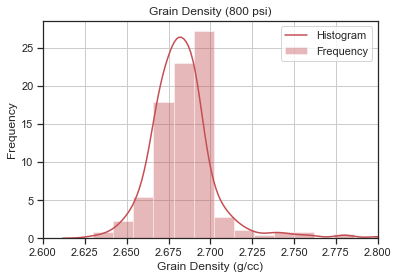

In [14]:
savefn = "Hist_800.png"
plot_grain_density(mod_df, "Grain Density (800 psi)", savefn)

#### Plotting the Effect of NOBP

C:\Users\mkumar\Anaconda3\lib\site-packages\matplotlib\collections.py:1039: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


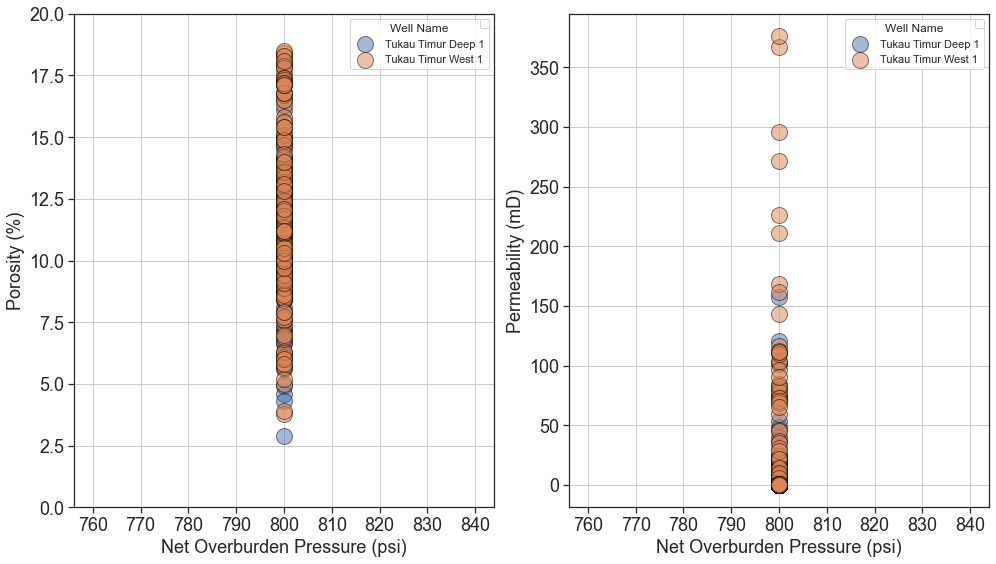

In [15]:
savefn = "NOBP_800.png"
plot_NOBP(mod_df, df_sub, grouped, color, savefn)

#### Plot cross-plot of Porosity-Permeability

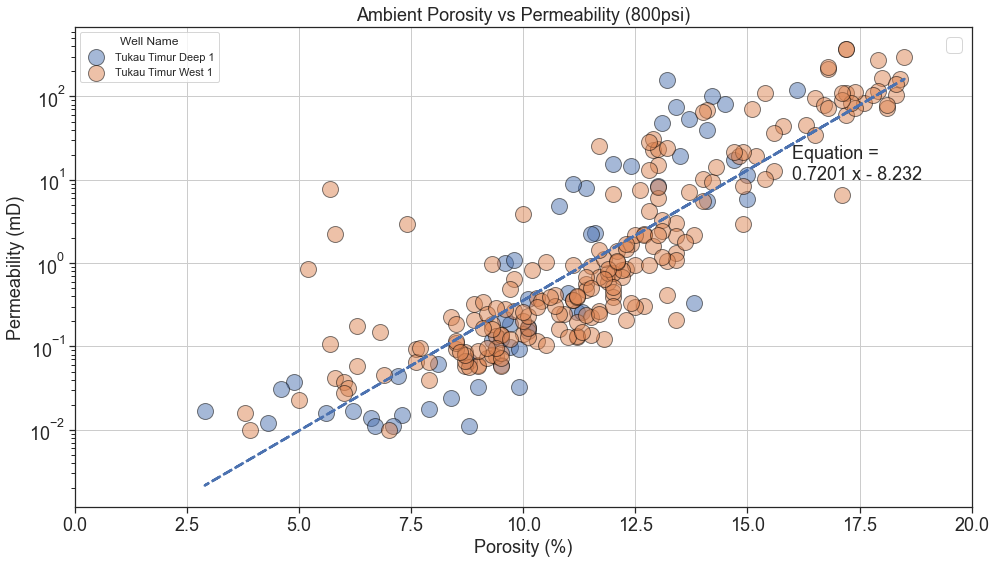

In [16]:
savefn = "Poro_Perm_800.png"

plot_PP(mod_df, df_sub, grouped, color, "Ambient Porosity vs Permeability (800psi)", savefn)

In [17]:
NOBP = 800

df_sub = mod_df[mod_df['NOB (psi)'] <= NOBP]
grouped = df_sub.groupby("Well Name")
color = df_sub['color']